Let's get the data loaded right away so that we don't have to think about it.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# Put the data you downloaded from the above link in the same folder as this tutorial.
# read data from a csv file
titanic_df = pd.read_csv('train.csv')

def first_letter(s):
    return str(s[0])

titanic_df['Cabin_Letter'] = titanic_df['Cabin'].fillna('Z').apply(first_letter)

In [28]:
Xdata = titanic_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_Letter', 'Embarked']]
Ydata = titanic_df['Survived']

Xdata = pd.get_dummies(Xdata, columns=['Pclass', 'Sex', 'Parch', 'Embarked', 'Cabin_Letter'])
Xdata = Xdata.fillna(-1)

In [29]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata)

# Hyperparameter Tuning

In this tutorial we will discuss "tuning" a model from scikit-learn.  So far we have created several models to predict which homes in Flint have dangerous water in their pipes.  However, for the most part these models have been "vanilla."  In other words, we have been using them with only default parameter values.  For example

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(Xtrain, Ytrain)
yhat1 = rf.predict_proba(Xtest)

## Model Evaluation

In order to discern whether a model is good or not we need metrics, or measurements, of model performance.  Today we will be focusing on classification.  Regression analysis requires a different set of metrics.

There are several different metrics for classification, each with drawbacks.  We will focus of AUROC scores and curves, which are good but not perfect general purpose metrics.

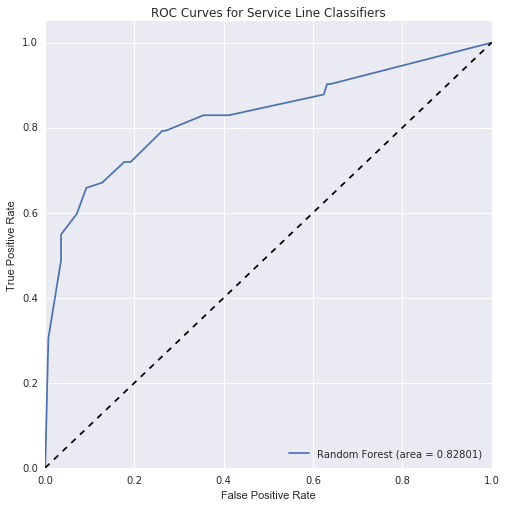

In [60]:
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve

fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat1[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

Hyperparameters are model-level variables that adjust how a model learns to discriminate between classes.  Each model in scikit-learn has several.  For example, we can adjust the n_estimators paramter for random forests as follows:

In [61]:
rf = RandomForestClassifier(n_estimators=1024, n_jobs=-1)
rf.fit(Xtrain, Ytrain)
yhat2 = rf.predict_proba(Xtest)

rf = RandomForestClassifier(n_estimators=1)
rf.fit(Xtrain, Ytrain)
yhat3 = rf.predict_proba(Xtest)

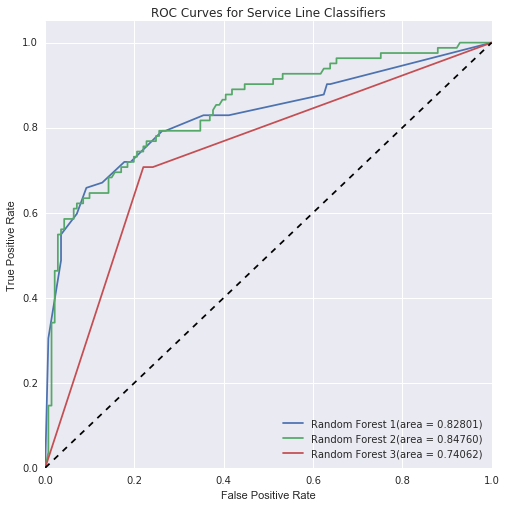

In [62]:

fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 1(area = %0.5f)' % roc(Ytest, yhat1[:,1]))

fpr, tpr, _ = roc_curve(Ytest, yhat2[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 2(area = %0.5f)' % roc(Ytest, yhat2[:,1]))

fpr, tpr, _ = roc_curve(Ytest, yhat3[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 3(area = %0.5f)' % roc(Ytest, yhat3[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

Changing this one parameter changed the score for our classifier  One choice decreased the score, and another increased it.  What other parameters does a random forest have?

In [34]:
rf = RandomForestClassifier(n_estimators=10, 
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None)

In [35]:
# Change some of the parameters of the random forest model above, and then run the code below.
# Experiment to see if you can improve the roc score.

rf.fit(Xtrain, Ytrain)
yhat = rf.predict_proba(Xtest)
print(roc(Ytest, yhat[:,1]))

0.812791904515


That's a lot.  What about a linear model?  Say, logistic regression?

In [52]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(penalty='l2',
                        dual=False,
                        tol=0.0001,
                        C=1.0,
                        fit_intercept=True,
                        intercept_scaling=1,
                        class_weight=None,
                        random_state=None,
                        solver='liblinear',
                        max_iter=100,
                        multi_class='ovr',
                        verbose=0,
                        warm_start=False,
                        n_jobs=1)

Not quite as many, but still a lot.  Normal human beings can't keep track of every parameter of every model.  Also, sotware evolves and can change.  There is no guarantee that if you learn all the parameters of all the models now that in a few years new parameters won't be introduced.  It is better to do what a typical mortal does - check the documentation.

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Random forest documentation</a>

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html">Ridge regression documentation</a>

So now we know that these parameters exist.  We know how to change them.  The next question: How should we choose them?  One way is to do an exhaustive search.  Rather than code one up ourselves, sklearn saves the day again.

In [39]:
from sklearn.model_selection import GridSearchCV


#GridSearchCV(estimator,            A model like random forest, linear regression, etc.
#            param_grid,            A dictionary of parameters to try
#            n_jobs=1,              Parallelize?
#            cv=None,               How many cross validation folds?
#            verbose=0,             How much do you want the function to talk to you?
#            error_score='raise')   What should the function do if a model breaks?

In [40]:
# First decide what kind of model you want to use.  We'll stick with a random forest.
# Create the object without changing any parameters.
rf = RandomForestClassifier()

# Now, create a dictionary of parameters to try.
param_dict={'n_estimators':[32, 64, 128, 256],
            'criterion':['gini', 'entropy'],
            'min_samples_split':[2,4,6]}

# Create the grid search classifier with your desired parameters.
grid_search_clf = GridSearchCV(rf, param_dict, n_jobs=-1, cv=3, verbose=3)

In [41]:
# Now we can fit and predict like any other model.
grid_search_clf.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] min_samples_split=2, n_estimators=32, criterion=gini ............
[CV] min_samples_split=2, n_estimators=32, criterion=gini ............
[CV] min_samples_split=2, n_estimators=32, criterion=gini ............
[CV] min_samples_split=2, n_estimators=64, criterion=gini ............
[CV] min_samples_split=2, n_estimators=64, criterion=gini ............
[CV] min_samples_split=2, n_estimators=128, criterion=gini ...........
[CV] min_samples_split=2, n_estimators=64, criterion=gini ............
[CV] min_samples_split=2, n_estimators=128, criterion=gini ...........
[CV]  min_samples_split=2, n_estimators=32, criterion=gini, score=0.780269, total=   0.1s
[CV]  min_samples_split=2, n_estimators=32, criterion=gini, score=0.829596, total=   0.1s
[CV] min_samples_split=2, n_estimators=128, criterion=gini ...........
[CV]  min_samples_split=2, n_estimators=32, criterion=gini, score=0.783784, total=   0.1s
[CV] min_samples_split=2, n_es

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s


[CV]  min_samples_split=6, n_estimators=64, criterion=gini, score=0.847534, total=   0.2s
[CV] min_samples_split=6, n_estimators=64, criterion=gini ............
[CV]  min_samples_split=6, n_estimators=64, criterion=gini, score=0.780269, total=   0.2s
[CV] min_samples_split=2, n_estimators=32, criterion=entropy .........
[CV]  min_samples_split=2, n_estimators=32, criterion=entropy, score=0.780269, total=   0.1s
[CV] min_samples_split=2, n_estimators=32, criterion=entropy .........
[CV]  min_samples_split=4, n_estimators=128, criterion=gini, score=0.852018, total=   0.5s
[CV] min_samples_split=2, n_estimators=32, criterion=entropy .........
[CV]  min_samples_split=6, n_estimators=64, criterion=gini, score=0.797297, total=   0.2s
[CV] min_samples_split=2, n_estimators=64, criterion=entropy .........
[CV]  min_samples_split=4, n_estimators=256, criterion=gini, score=0.847534, total=   1.1s
[CV]  min_samples_split=6, n_estimators=128, criterion=gini, score=0.793722, total=   0.4s
[CV] min_

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    5.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 6], 'n_estimators': [32, 64, 128, 256], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [42]:
yhat_g = grid_search_clf.predict_proba(Xtest)

# Which parameters worked the best?
print(grid_search_clf.best_params_)

{'min_samples_split': 6, 'n_estimators': 64, 'criterion': 'entropy'}


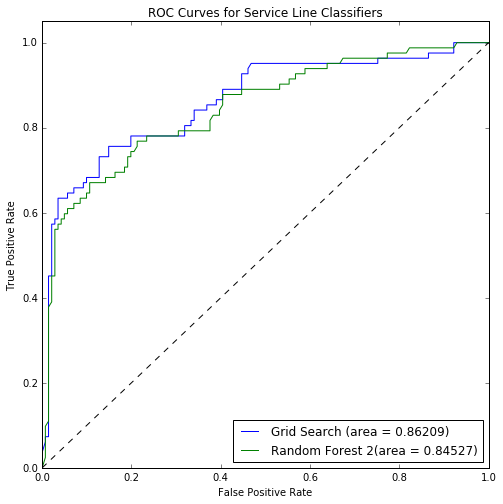

In [43]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat_g[:,1])
plt.plot(fpr, tpr, label= 'Grid Search (area = %0.5f)' % roc(Ytest, yhat_g[:,1]))

fpr, tpr, _ = roc_curve(Ytest, yhat2[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 2(area = %0.5f)' % roc(Ytest, yhat2[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

Learning curves are another very important tool to measure model performance.  Given a model, we can construct it's learning curve as follows:

1. Train the model on a small amount of training data.  Measure it's training score and test score.
2. Increase the amount of data that you train on by a small amount.
3. Go To 1.

In [56]:
from sklearn.model_selection import learning_curve
import seaborn

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.01, 1.0, 30),
                        legend=False, verbose=0):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """

    plt.title(title, size=20)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", size=20)
    plt.ylabel("AUROC", size=20)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")

    if legend:
        plt.legend(loc="best", prop={'size':18})
    
    print("Mean CV Score w/Full Data: %.2f +\- %.2f" % (test_scores_mean[-1], test_scores_std[-1]))
    
    return plt

Creating Dump Random Forest
Mean CV Score w/Full Data: 0.74 +\- 0.05
Creating 'Smart' Random Forest
Mean CV Score w/Full Data: 0.87 +\- 0.05


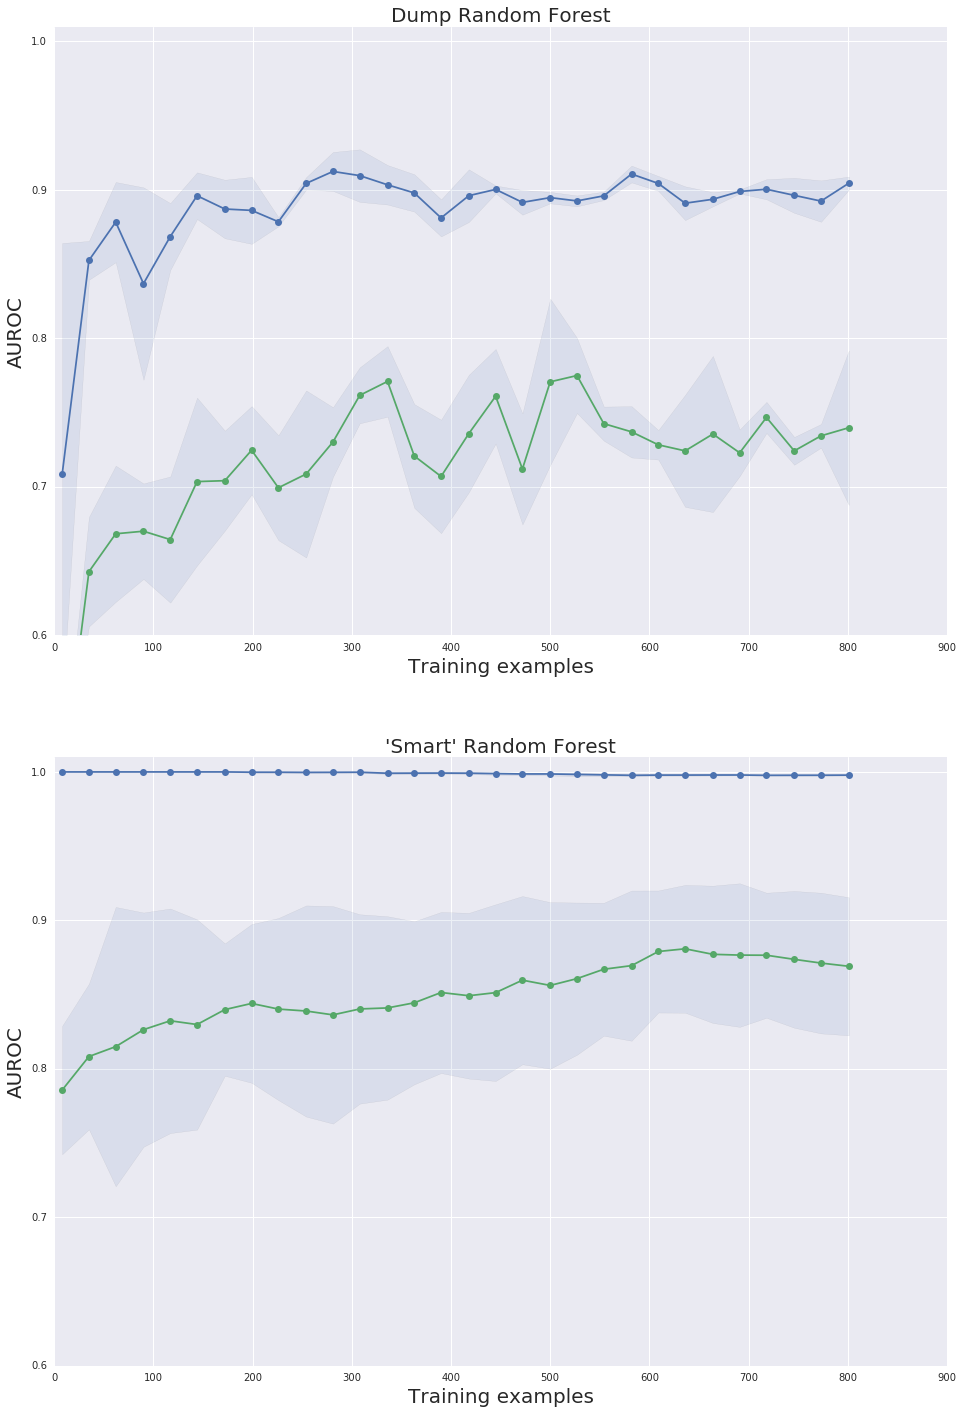

In [59]:
X, y = Xdata, Ydata

titles = ["Dumb Random Forest", "\'Smart\' Random Forest"]

cv = StratifiedShuffleSplit(n_splits=3)
#cv = StratifiedKFold(n_splits=10)

models = [RandomForestClassifier(n_estimators=1),
          RandomForestClassifier(n_estimators=512, max_depth=24, criterion='entropy')]

subplots = [211, 212]

plt.figure(figsize=(16,24))
for i, (model, title, subplot) in enumerate(zip(models, titles, subplots)):
    print("Creating " + title)
    plt.subplot(subplot)
    if i == 2:
        plot_learning_curve(model, title, X, y, (0.6, 1.01), cv=cv, n_jobs=7, legend=True)
    else:
        plot_learning_curve(model, title, X, y, (0.6, 1.01), cv=cv, n_jobs=7)